# Here we make a Random Forest Model For Prochlorococcus


In [1]:
# Set a working directory
#!pip install GitPython
import git
import os

repo = git.Repo('.', search_parent_directories=True)


os.chdir(repo.working_tree_dir)

###  Running the model preparation notebook

In [2]:
# Running model preperation notebook that has a function we need to call
%run 'python/04_Populations-model-fitting/01_model-preparation.ipynb'
#%run '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/python/04_Populations-model-fitting/01_model-preparation.ipynb'


[[ 3.49023765e+01  2.43392647e+01 -2.28452622e-02 ...  3.37754147e-05
   1.95487665e+03  2.03823530e-02]
 [ 3.48805900e+01  2.43207250e+01 -2.19817645e-02 ...  3.09030475e-05
   1.95626175e+03  8.56500000e-02]
 [ 3.48840526e+01  2.43108263e+01 -2.19817645e-02 ...  3.09030475e-05
   1.95626175e+03  8.59157890e-02]
 ...
 [ 3.34713633e+01  1.53143378e+01  3.63295805e-01 ...  7.55719400e-04
   2.00841777e+03  5.68868550e+02]
 [ 3.34681505e+01  1.51890208e+01  3.63295805e-01 ...  7.55719400e-04
   2.00841777e+03  1.27692150e+02]
 [ 3.34788456e+01  1.53273022e+01  3.63295805e-01 ...  7.55719400e-04
   2.00841777e+03  1.01280000e+00]]
[10.52044346  9.3093869   9.4065122  ...  0.72024412  0.76845579
  0.87459865]
[   0    1    2 ... 2389 2390 2391] [   8   13   18   20   23   25   29   30   32   43   44   45   48   49
   51   56   59   63   65   67   69   70   71   73   76   78   83   84
   87   96   99  100  105  109  111  115  118  120  121  124  128  134
  135  149  157  162  163  168  173 

In [3]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib

### First we are making a graph to determine the best testing to training ratio 

This is using a function that we defined in notebook 01_model-preparation

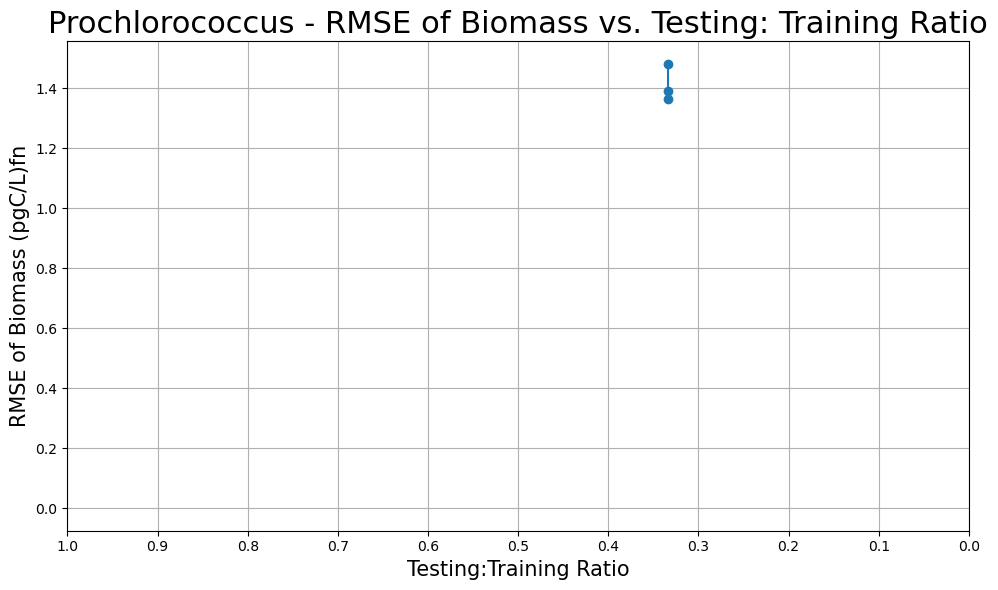

In [11]:
#using a function defined in the model preparation notebook
RMSEs = testing_training_ratio(features = features_pro, labels = labels_pro,
                               feature_list=feature_list_pro, title_prefix="Prochlorococcus")


## RF Regressor for Prochlorococcus

Here we are first calling a function defined in the model preparation notebook to find the optimal number of decision trees for out model, and then we are assembling a random forest regressor model for the prochlorococcus population.  This is then saved in a joblib file for future use.

In [5]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for k-fold cross-validation
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=False)

# Initialize lists to hold training and testing data
train_features = []
test_features = []
train_labels = []
test_labels = []

# Split the data into training and testing sets for each fold
for train_index, test_index in kf.split(features_pro):
    train_feat, test_feat = features_pro[train_index], features_pro[test_index]
    train_lab, test_lab = labels_pro[train_index], labels_pro[test_index]
    
    # Append the training and testing data for this fold to the lists
    train_features.append(train_feat)
    test_features.append(test_feat)
    train_labels.append(train_lab)
    test_labels.append(test_lab)


/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do

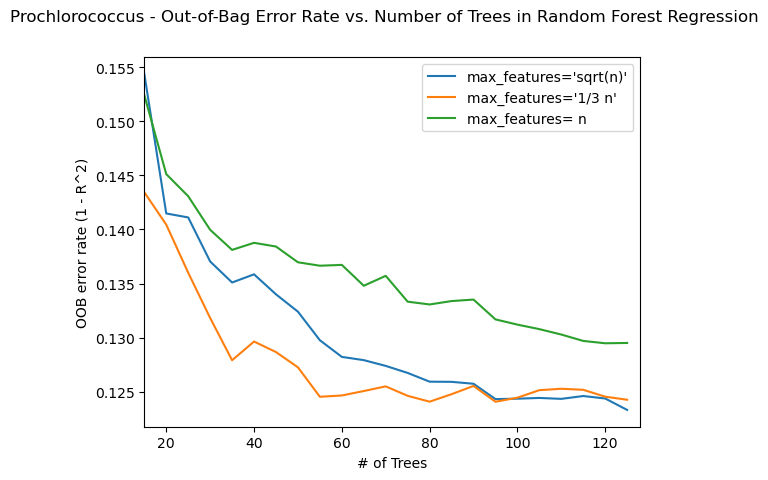

In [6]:
plot_oob_error_vs_num_trees(train_features, train_labels, title_prefix="Prochlorococcus")

In [7]:
# Looking at the shape of the features and labels to see if they match up
import numpy
lengths = [len(sublist) for sublist in train_features]
print(set(lengths))
print(type(train_features))
print(type(train_labels))
train_features = numpy.array(train_features)
train_labels = numpy.array(train_labels)
test_features = numpy.array(test_features)
test_labels = numpy.array(test_labels)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

{1794}
<class 'list'>
<class 'list'>
Training Features Shape: (4, 1794, 16)
Training Labels Shape: (4, 1794)
Testing Features Shape: (4, 598, 16)
Testing Labels Shape: (4, 598)


In [9]:
# We are using a regressor RF model because we are predicting on continous values
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_features='sqrt', random_state = 43)
# Use the Training data to build the model
rf.fit(train_features, train_labels)
#saving the model
joblib.dump(rf, "RF_models/pro_random_forest.joblib")


## Predicting and Testing for Prochlorococus

Now that we have a model, it's time to test it.  These following functions compare the predictions from out random forest model to actual data, and then use this comparison to give us feature importance.  

In [10]:
# Convert test_features to a DataFrame
test_features_df = pd.DataFrame(test_features, columns=feature_list_pro)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Create a new Series with predicted values and index from test_features_df
predic_biomass = pd.Series(predictions, index=test_features_df.index)

# Assign the new Series to the DataFrame using .loc
test_features_df.loc[:, 'Prediction'] = predic_biomass

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

# Finding the root mean square error (RMSE)
from sklearn.metrics import mean_squared_error
# RMSE give realtively high weight to large errors 
RMSE = mean_squared_error(test_labels, predictions, squared=False) #setting squared=False gives us RMSE not MSE

# Calculate the percentage of RMSE
range_target = test_labels.max() - test_labels.min()
percentage_RMSE = (RMSE / range_target) * 100

print('Root Mean Squared Error:', round(RMSE, 2), 'pgC per L.')
print('Percentage of RMSE:', round(percentage_RMSE, 2), '%')


ValueError: Must pass 2-d input. shape=(4, 598, 16)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_pro, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# Make a bar chart
plt.bar(x=feature_importance.index,height=feature_importance[0], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(feature_importance.index, rotation=45, ha='right', rotation_mode='anchor')

# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances for Pro RF');

### Permutation importance as a method of assessing feature importance

Permutation importance tests feature importance by permuting branches on RF trees to asses the impact of changing specific variables on the prediction.  This is an additional way to validate our feature importance.

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.DataFrame(result.importances_mean, index=feature_list_pro).sort_values(by=0, ascending=False)
forest_importances.to_csv('data/modified/pro_permutation_importance.csv', index=False)


In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Comparing predicted biomass vs actual

In [ ]:
fig, axs = plot_model_predictions()

axs[1].set_title('Prochlorococcus')

In [ ]:
# Call the function and store the figure and axes objects
# Assuming plot_model_predictions_density() generates a plot and returns the figure and axes objects
fig, ax = plot_model_predictions_density()

# Set the title for the single subplot
ax.set_xlim(0, 15)  # Example x-axis limits
ax.set_ylim(0, 15)  # Example y-axis limits
    
ax.set_title('Prochlorococcus', fontsize=20)



# Display Legend
ax.legend(loc="lower right", )

plt.tick_params(axis='both', which='major', labelsize=16)  # Adjust the fontsize




# Display the plot with the updated title
plt.show()


In [ ]:
from sklearn.metrics import r2_score
r2_score(test_labels, predictions)